In [140]:
from vmad import Builder
from vmad import autooperator
from vmad import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
from nbodykit.cosmology import Planck15
from nbodykit.cosmology.power.transfers import NoWiggleEisensteinHu
from vmad.core.stdlib.operators import mul, div, add, sub
from vmad.core.stdlib.operators import pow as power
from vmad.lib.linalg import reshape

import matplotlib.pyplot as plt
%matplotlib notebook

# Max's attempt :(

\begin{equation}
\begin{split}
    T_0 = \dfrac{ln(2e+1.8q_{eff})}{ln(2e+1.8q_{eff})+cq_{eff}^2}\\
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial T_0}{\partial q_{eff}} &= \dfrac{1}{\left(ln(2e+1.8q_{eff})+cq_{eff}^2\right)\left(2e+1.8q_{eff}\right)}\left[1.8 - \dfrac{ln(2e+1.8q_{eff})}{\left(ln(2e+1.8q_{eff}) +cq_{eff}^2\right)}\left(1.8+2cq_{eff}(2e+1.8q_{eff})\right)\right]\\
\dfrac{\partial T_0}{\partial c} &= -\dfrac{ln(2e+1.8q_{eff})q_{eff}^2}{\left(ln(2e+1.8q_{eff})+cq_{eff}^2\right)^2}
\end{split}
\end{equation}


In [8]:
@operator
class T0:
    ain = 'q_eff', 'c'
    aout = 'T_0'

    def apl(node, q_eff, c, theta_cmb):
        return dict(T_0=np.log(2 * np.e + 1.8 * q_eff) /
                    (np.log(2 * np.e + 1.8 * q_eff) + c * q_eff**2))

    def vjp(node, _T_0, q_eff, c, theta_cmb):
        _q_eff = 1/((np.log(2*np.e+1.8*q_eff)+c*q_eff**2)*(2*np.e+1.8*q_eff)) \
            *(1.8-np.log(2*np.e+1.8*q_eff)/(np.log(2*np.e+1.8*q_eff)+c*q_eff**2) \
              *(1.8+2*c*q_eff*(2*np.e+1.8*q_eff)))

        _c = -np.log(2 * np.e + 1.8 * q_eff) * (q_eff**2) / (
            np.log(2 * np.e + 1.8 * q_eff) + c * q_eff**2)**2
        print('T0')
        return dict(_q_eff=_q_eff * _T_0, _c=_c * _T_0)

    def jvp(node, q_eff_, c_, q_eff, c, theta_cmb):
        q_eff_ *= 1/((np.log(2*np.e+1.8*q_eff)+c*q_eff**2)*(2*np.e+1.8*q_eff)) \
            *(1.8-np.log(2*np.e+1.8*q_eff)/(np.log(2*np.e+1.8*q_eff)+c*q_eff**2) \
              *(1.8+2*c*q_eff*(2*np.e+1.8*q_eff)))

        c_ *= -np.log(2 * np.e + 1.8 * q_eff) * (q_eff**2) / (
            np.log(2 * np.e + 1.8 * q_eff) + c * q_eff**2)**2

        return dict(T_0_=q_eff_ + c_)

\begin{equation}
    q = \dfrac{k}{13.41k_{eq}}
\end{equation}

In [9]:
@operator
class q:
    ain = 'k_eq'
    aout = 'q'

    def apl(node, k_eq, k):
        return dict(q=k / (13.41 * k_eq))
        #return dict(q = k*theta_cmb**2/(13.81*7.46e-2*(omega0_m*h**2))**(-2))

    def vjp(node, _q, k_eq, k):
        _k_eq = -13.41 * k / (13.41 * k_eq)**2
        print('k_eq')
        return dict(_k_eq=_k_eq * _q)

    def jvp(node, k_eq_, k):
        k_eq_ *= -13.41 * k / (13.41 * k_eq)**2

        return dict(q_=k_eq_)

\begin{equation}
    c = 14.2 + \dfrac{731}{1+62.5q_{eff}}
\end{equation}

In [10]:
@operator
class c:
    ain = 'q_eff'
    aout = 'c'

    def apl(node, q_eff):
        return dict(c=14.2 + 731 / (1 + 62.5 * q_eff))

    def vjp(node, _c, q_eff):
        _q_eff = -731 * 62.5 / (1 + 62.5 * q_eff)**2
        print('c')
        return dict(_q_eff=_q_eff * _c)

    def jvp(node, q_eff_, q):
        pass
        q_eff_ *= -731 * 62.5 / (1 + 62.5 * q_eff)**2
        return dict(c_=q_eff_)

\begin{equation}
     s =\dfrac{44.5h\ln(9.83/\Omega_0 h^2)}{\sqrt{1+10(\Omega_{0,b}h^2)^{.75}}}
\end{equation}

\begin{equation}
\dfrac{\partial s}{\partial \Omega_0} = -\dfrac{44.5h}{\Omega_0\sqrt{1+10(\Omega_{0,b}h^2)^{.75}}}
\end{equation}

In [11]:
@operator
class s:
    ain = 'omega0_m'
    aout = 's'

    def apl(node, omega0_m, omega0_b):
        s = 44.5 * h * np.log(
            9.83 / (omega0_m * h**2)) / np.sqrt(1 + 10 *
                                                (omega0_b * h**2)**(.75))
        print(s)
        return dict(s=s)

    def vjp(node, _s, omega0_m, omega0_b):
        _omega0_m = -44.5 * h / (omega0_m * np.sqrt(1 + 10 *
                                                    (omega0_b * h**2)**(.75)))
        print('s')
        return dict(_omega0_m=omega0_m * _s)

    def jvp(node, omega0_m_, omega0_m, omega0_b):
        omega0_m_ *= -44.5 * h / (omega0_m * np.sqrt(1 + 10 *
                                                     (omega0_b * h**2)**(.75)))

        return dict(s_=omega0_m_)

\begin{equation}
k_{eq} = .0746\Omega_0h^2\Theta_{2.7}^{-2}
\end{equation}

In [12]:
@operator
class k_eq:
    ain = 'omega0_m'
    aout = 'k_eq'

    def apl(node, omega0_m, theta_cmb):
        k_eq = .0746 * omega0_m * h**2 * theta_cmb**(-2)
        return dict(k_eq=k_eq)

    def vjp(node, _k_eq, omega0_m, theta_cmb):
        _omega0_m = .0746 * h**2 * theta_cmb**(-2)
        print('k_eq')
        return dict(_omega0_m=_omega0_m * _k_eq)

    def jvp(node, omega0_m_, omega0_m, theta_cmb):
        omega0_m_ *= .0746 * h**2 * theta_cmb**(-2)
        return dict(k_eq_=omega0_m)

\begin{equation}
    \Gamma = 1-.328\ln(431\Omega_0h^2)\dfrac{\Omega_{0,b}}{\Omega_0}+.38\ln(22.3\Omega_0h^2)\dfrac{\Omega_{0,b}^2}{\Omega_0^2}
\end{equation}

\begin{equation}
\dfrac{\partial \Gamma}{\partial \Omega_0}=-.328\dfrac{\Omega_{0,b}}{\Omega_0^2}\left[1-ln(431\Omega_0 h^2)\right]+.38\dfrac{\Omega_{0,b}}{\Omega_0^3}\left[1-2\ln(22.3\Omega_0h^2)\right]
\end{equation}

In [13]:
@operator
class gamma:
    ain = 'omega0_m'
    aout = 'gamma'

    def apl(node, omega0_m, omega0_b):
        f = omega0_b / omega0_m
        gamma = 1 - .328 * np.log(431 * omega0_m * h**2) * f + .38 * np.log(
            22.3 * omega0_m * h**2) * f**2
        return dict(gamma=gamma)

    def vjp(node, _gamma, omega0_m, omega0_b):
        _omega0_m = -.328*omega0_b/omega0_m**2*(1-np.log(431*omega0_m*h**2)) \
                    +.38*omega0_b**2/omega0_m**3*(1-2*np.log(22.3*omega0_m*h**2))
        print('gamma')
        return dict(_omega0_m=_omega0_m * _gamma)

    def jvp(node, omega0_m_, omega0_m, omega0_b):
        omega0_m_ *= -.328*omega0_b/omega0_m**2*(1-np.log(431*omega0_m*h**2)) \
                    +.38*omega0_b**2/omega0_m**3*(1-2*np.log(22.3*omega0_m*h**2))
        return dict(gamma_=omega0_m_)

\begin{equation}
\Gamma_{eff} =\Omega_0h^2\left(\Gamma+ \dfrac{1-\Gamma}{1+(.43ks/h)^4}\right)
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial \Gamma_{eff}}{\partial \Omega_0} &= h^2\left(\Gamma+ \dfrac{1-\Gamma}{1+(.43ks/h)^4}\right)\\
\dfrac{\partial \Gamma_{eff}}{\partial \Gamma} &= \Omega_0 h^2\\
\dfrac{\partial \Gamma_{eff}}{\partial s} &= \dfrac{-4\Omega h^2(1-\Gamma)(.43ks/h)^4}{s(1+(.43ks/h)^4)^2}
\end{split}
\end{equation}

In [14]:
@operator
class gamma_eff:
    ain = 'omega0_m', 'gamma', 's'
    aout = 'gamma_eff'

    def apl(node, omega0_m, gamma, s, k):
        gamma_eff = omega0_m * h**2 * (gamma + (1 - gamma) /
                                       (1 + (.43 * k * s / h)**4))
        return dict(gamma_eff=gamma_eff)

    def vjp(node, _gamma_eff, omega0_m, gamma, s, k):
        _omega0_m = h**2 * (gamma + (1 - gamma) / (1 + (.43 * k * s / h)**4))
        _gamma = omega0_m * h**2
        _s = -4 * omega0_m * h**2 * (1 - gamma) * (.43 * k * s / h)**4 / (
            s * (1 + (.43 * k * s / h)**4)**2)
        print('gamma_eff')
        return dict(_omega0_m=_omega0_m * _gamma_eff,
                    _gamma=_gamma * _gamma_eff,
                    _s=_s * _gamma_eff)

    def jvp(node, omega0_m_, gamma_, s_, omega0_m, gamma, s, k):
        omega0_m_ *= h**2 * (gamma + (1 - gamma) / (1 + (.43 * k * s / h)**4))
        gamma_ *= omega0_m * h**2
        s_ *= -4 * omega0_m * h**2 * (1 - gamma) * (.43 * k * s / h)**4 / (
            s * (1 + (.43 * k * s / h)**4)**2)
        return dict(gamma_eff_=omega0_m_ + gamma_ + s_)

\begin{equation}
q_{eff} = \dfrac{q\Omega_0 h^2}{\Gamma_{eff}}
\end{equation}

In [15]:
@operator
class q_eff:
    ain = 'omega0_m', 'q', 'gamma_eff'
    aout = 'q_eff'

    def apl(node, omega0_m, q, gamma_eff):
        return dict(q_eff=q * omega0_m * h**2 / gamma_eff)

    def vjp(node, _q_eff, omega0_m, q, gamma_eff):
        _omega0_m = q * h**2 / gamma_eff
        _q = omega0_m * h**2 / gamma_eff
        _gamma_eff = -q * omega0_m * h**2 / gamma_eff**2
        return dict(_omega0_m=_omega0_m * _q_eff,
                    _q=_q * _q_eff,
                    _gamma_eff=_gamma_eff * _q_eff)

    def jvp(node, omega0_m_, q_, gamma_eff_, omega0_m, q, gamma_eff):
        omega0_m_ *= q * h**2 / gamma_eff
        q_ *= omega0_m * h**2 / gamma_eff
        gamma_eff_ *= -q * omega0_m * h**2 / gamma_eff**2
        return dict(q_eff_=omega0_m_ + q_ + gamma_eff_)

\begin{equation}
\dfrac{k^3}{2\pi^2}P(k,z) = \delta_H^2\left(\dfrac{ck}{H_0}\right)^{3+n}T^2(k,z)\dfrac{D_1^2(z)}{D_1^2(0)}
\end{equation}

In [16]:
@autooperator('omega0_m->P')
def powerrr(omega0_m, k, z, n, theta_cmb):
    k = k * h

    factor = 2 * np.pi**2 / k**3 * (cosmo.C * k / cosmo.H0)**(3 + n)

    delta_h = power(amplitude(omega0_m, n), 2)

    sound_horizon = s(omega0_m, cosmo.Omega0_b)

    gamma_alpha = gamma(omega0_m, cosmo.Omega0_b)

    k_eqs = k_eq(omega0_m, theta_cmb)

    gamma_effs = gamma_eff(omega0_m, gamma_alpha, sound_horizon, k)

    qs = q(k_eqs, k)

    q_effs = q_eff(omega0_m, qs, gamma_effs)

    cs = c(q_effs)

    omega_zs = omega_z(omega0_m, z)
    omega_lambdas = omega_lambda(omega0_m, z)

    transfer = power(T0(q_effs, cs, theta_cmb), 2)

    growth_z = power(growth(omega_zs, omega_lambdas, z), 2)
    growth_0 = power(growth(omega_zs, omega_lambdas, 0), 2)

    g_tot = growth_z
    amp = mul(factor, delta_h)
    amp = mul(amp, g_tot)

    P = mul(amp, transfer)
    P = div(mul(P, div(cosmo.Omega0_cdm, omega0_m)), h**3)

    return dict(P=P)

In [17]:
cosmo = cosmo.clone(P_k_max=50)

In [18]:
cosmo.Omega0_r

7.891574797365186e-05

In [19]:
h = cosmo.h
k = np.linspace(1e-2, 50, 1e4)

m = powerrr.build(k=k, z=10, n=1, theta_cmb=cosmo.T0_cmb / 2.7)
init = dict(omega0_m=cosmo.Omega0_m)
p, tape_power = m.compute(init=init, vout=['P'], return_tape=True)
cos_pow = cosmo.get_pk(k, 10)
error = np.abs(p[0] - cos_pow)

101.86639817595847


In [20]:
vjp = tape_power.get_vjp()

In [21]:
vjp_init = dict(_P=1)
_omega0_m = vjp.compute(init=vjp_init, vout=['_omega0_m'], monitor=None)

T0
c
k_eq
gamma_eff
k_eq
gamma
s


In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


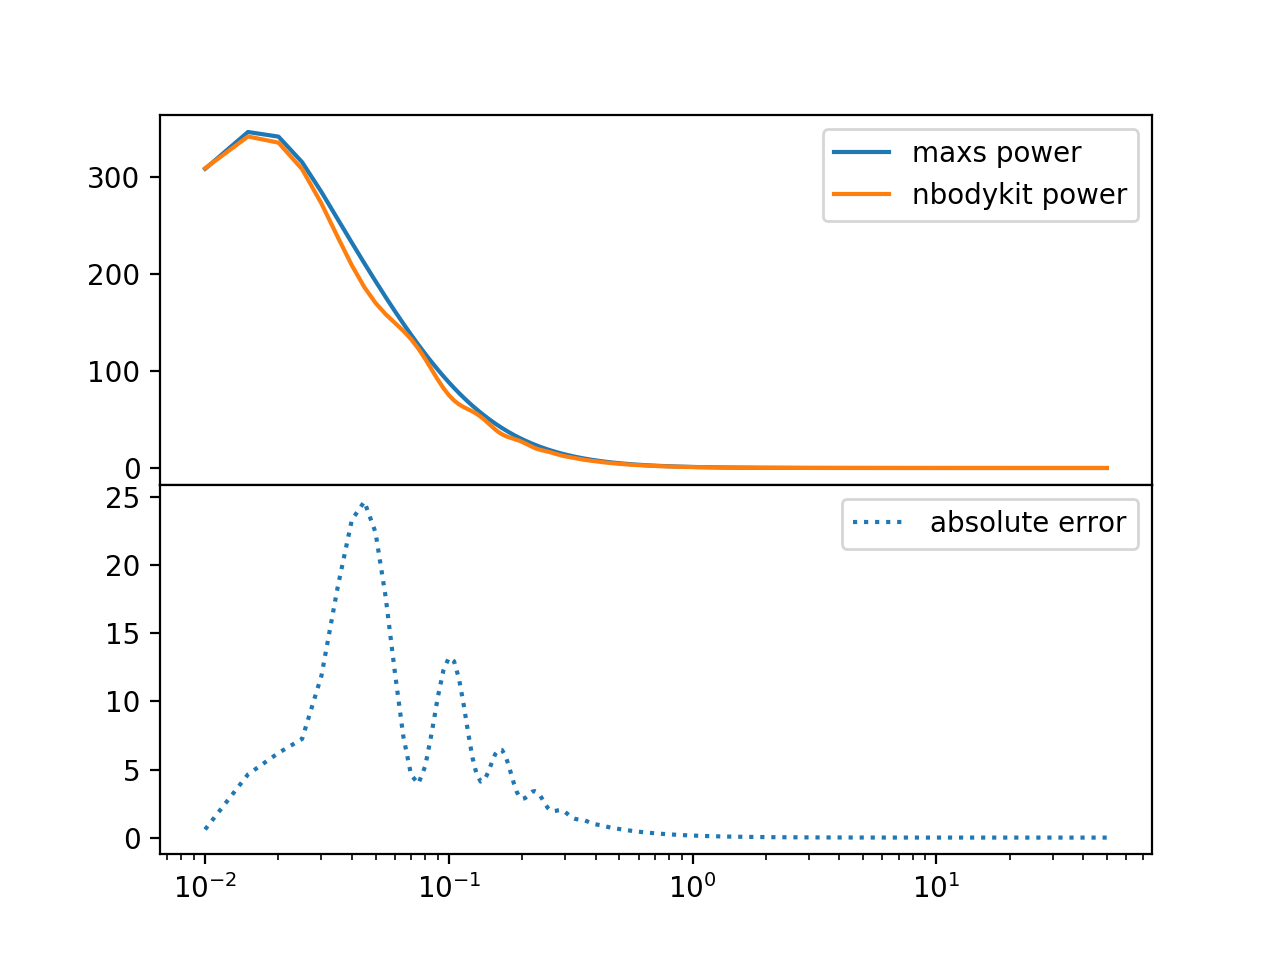

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0})
ax1.semilogx(k, p[0], label='maxs power')
ax1.semilogx(k, cos_pow, label='nbodykit power')
# ax1.semilogx(k, cos_ho.__call__(k)**2*a/1.78)

ax1.legend()
ax2.semilogx(k, error, ':', label='absolute error')
ax2.legend()

<IPython.core.display.Javascript object>


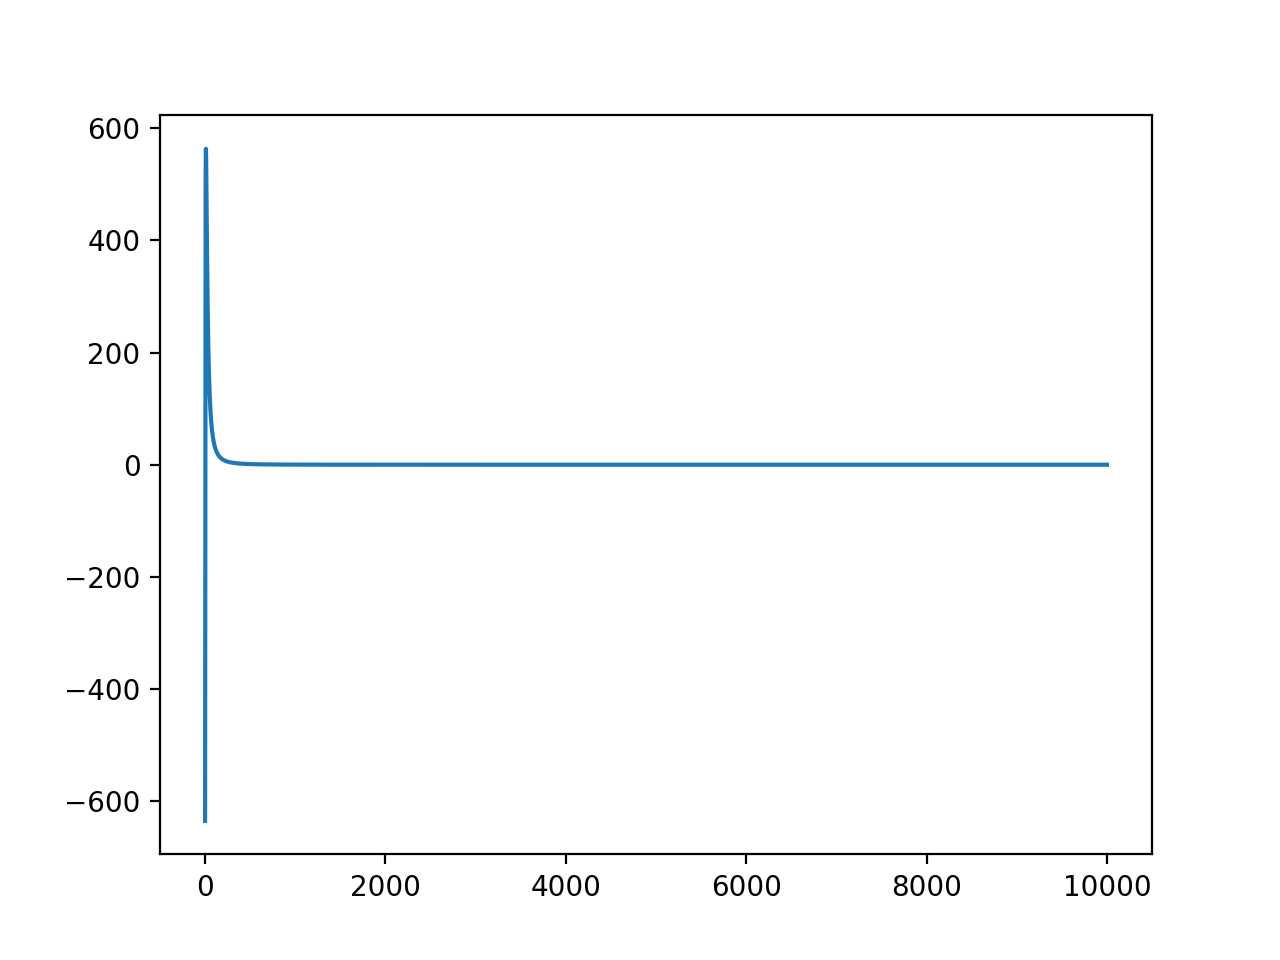

In [24]:
plt.figure()
plt.plot(_omega0_m[0])

# Einstein Ho no wiggles remixxxx

In [43]:
cosmo = Planck15
cosmo = cosmo.match(sigma8=.8158)
cosmo = cosmo.clone(P_k_max=50)

In [10]:
@operator
class log:
    ain = 'x'
    aout = 'y'

    def apl(node, x):
        return dict(y=np.log(x))

    def vjp(node, _y, x):
        return dict(_x=1 / x * _y)

    def jvp(node, x_, x):
        return dict(y_=1 / x * x_)

\begin{equation}
\delta_H = 1.94\times 10^{-5}\Omega_{m,0}^{-.785-.05ln(\Omega_{m,0})}e^{-.95n-.169n^2}
\end{equation}

\begin{equation}
\delta_H' = 1.94\times 10^{-5}\left(-.785 + .05\ln(\Omega_{m,0})\right)\Omega_{m,0}^{-1.785 + .05\ln(\Omega_{m,0})}e^{-.95n-.169n^2}\dfrac{.05}{\Omega_{m,0}}
\end{equation}

In [11]:
@operator
class amplitude:
    ain = 'omega0_m'
    aout = 'delta_h'

    def apl(node, omega0_m, n):
        factor_1 = 1.94e-5 * omega0_m**(-.785 - .05 * np.log(omega0_m))
        factor_2 = np.e**(-.95 * (n - 1) - .169 * (n - 1)**2)

        return dict(delta_h=factor_1 * factor_2)

    def vjp(node, _delta_h, omega0_m, n):
        factor_1 = 1.94e-5*(-.785+.05*np.log(omega0_m))*.05/omega0_m\
                    * omega0_m**(-1.785-.05*np.log(omega0_m))

        factor_2 = np.e**(-.95 * (n - 1) - .169 * (n - 1)**2)
        return dict(_omega0_m=factor_1 * factor_2 * _delta_h)

    def jvp(node, omega0_m_, omega0_m, n):
        factor_1 = 1.94e-5*(-.785+.05*np.log(omege0_m))*.05/omega0_m \
                    * omega0_m**(-1.785-.05*np.log(omega0_m))
        factor_2 = np.e**(-.95 * (n - 1) - .169 * (n - 1)**2)

        return dict(delta_h_=factor_1 * factor_2 * omega0_m_)

\begin{equation}
    D_1(z) = (1+z)^{-1}\dfrac{5\Omega(z)}{2}\left[\Omega(z)^{4/7}-\Omega_\Lambda(z) +(1+\Omega(z)/2)(1+\Omega_\Lambda(z)/70)\right]^{-1}
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial D_1(z)}{\partial \Omega} &= \dfrac{(1+z)^{-1}\dfrac{5}{2}}{\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\left[1 - \dfrac{\Omega(z)\left( 4/7 \Omega (z)^{-3/7}+1/2+\Omega_\Lambda(z)/140\right)}{[\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\right]\\
\dfrac{\partial D_1(z)}{\partial \Omega_\Lambda} &= -\dfrac{5\Omega (z)(-1+1/70+\Omega(z)/140)}{2(1+z)(\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70))^2}
\end{split}
\end{equation}


In [12]:
@operator
class growth:
    ain = 'omega_z', 'omega_lambda'
    aout = 'growth'

    def apl(node, omega_z, omega_lambda, z):
        growth = (1 + z)**(-1) * 5 * omega_z / 2 * (
            omega_z**(4 / 7) - omega_lambda + (1 + omega_z / 2) *
            (1 + omega_lambda / 70))**(-1)
        return dict(growth=growth)

    def vjp(node, _growth, omega_z, omega_lambda, z):
        _omega_z = (1+z)**(-1)*5/2*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1)\
                    *(1- omega_z*(4/7*omega_z**(-3/7)+1/2+omega_lambda/140)\
                     *(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1))

        _omega_lambda = 5*omega_z*(-1+1/70+omega_z/140)/(2*(1+z)*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)\
                                                                  *(1+omega_lambda/70))**(-2))
        return dict(_omega_z=_omega_z * _growth,
                    _omega_lambda=_omega_lambda * _growth)

    def jvp(node, omega_z_, omega_lambda_, omega_z, omega_lambda, z):
        omega_z_ *= (1+z)**(-1)*5/2*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1)\
                    *(1- omega_z*(4/7*omega_z**(-3/7)+1/2+omega_lambda/140)\
                     *(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1))
        omega_lambda_ *= 5*omega_z*(-1+1/70+omega_z/140)/(2*(1+z)*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)\
                                                                  *(1+omega_lambda/70))**(-2))
        return dict(growth_=omega_z_ + omega_lambda_)

\begin{equation}
\Omega(z) = \dfrac{\Omega_0 (1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega(z)}{\partial \Omega_{0}} = \dfrac{(1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}\left[1 - \dfrac{\Omega_0 (1+z)^3}{\left(\Omega_\Lambda+\Omega_0(1+z)^3\right)}\right]
\end{equation}

In [13]:
@operator
class omega_z:
    ain = 'omega0_m'
    aout = 'omega_z'

    def apl(node, omega0_m, z):
        omega0_l = 1 - omega0_m
        return dict(omega_z=omega0_m * (1 + z)**3 / (omega0_l + omega0_m *
                                                     (1 + z)**3))

    def vjp(node, _omega_z, omega0_m, z):
        _omega0_m = (1+z)**3/(1-omega0_m +omega0_m*(1+z)**3)\
                    *(1 - omega0_m*(1+z)**3/(1-omega0_m +omega0_m*(1+z)**3))
        return dict(_omega0_m=_omega0_m * _omega_z)

    def jvp(node, omega0_m_, omega0_m, z):
        omega0_m_ *= (1+z)**3/(omega0_l +omega0_m*(1+z)**3)\
                    *(1 - omega0_m*(1+z)**3/(omega0_l +omega0_m*(1+z)**3))
        return dict(omega_z_=omega0_m_)

\begin{equation}
\Omega_\Lambda(z) = \dfrac{1-\Omega_0}{1-\Omega_0 + \Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega_\Lambda(z)}{\partial \Omega_0} = \dfrac{-1}{1-\Omega_0 +\Omega_0(1+z)^3} - \dfrac{1-\Omega_0(-1+(1+z)^3)}{\left(1-\Omega_0+\Omega_0(1+z)^3\right)^2}
\end{equation}

In [14]:
@operator
class omega_lambda:
    ain = 'omega0_m'
    aout = 'omega_lambda'

    def apl(node, omega0_m, z):
        omega0_l = 1 - omega0_m
        return dict(omega_lambda=omega0_l / (omega0_l + omega0_m * (1 + z)**3))

    def vjp(node, _omega_lambda, omega0_m, z):
        _omega0_m = -1/(1-omega0_m+omega0_m*(1+z)**3)*(1+(1-omega0_m*((1+z)**3-1))\
                                                       /(1-omega0_m +omega0_m*(1+z)**3))
        return dict(_omega0_m=_omega0_m * _omega_lambda)

    def jvp(node, omega0_m_, omega0_m, z):
        omega0_m_ *= -1/(1-omega0_m+omega0_m*(1+z)**3)*(1+(1-omega0_m*((1+z)**3-1))\
                                                       /(1-omega0_m +omega0_m*(1+z)**3))
        return dict(omega_lambda_=omega0_m_)

In [160]:
@autooperator('Omega0_m->Pk')
def get_pklin(Omega0_m, Omega0_b, h, Tcmb0, C, H0, n, z, k):

    Obh2 = Omega0_b * h**2
    Omh2 = mul(Omega0_m, power(h, 2))
    f_baryon = div(Omega0_b, Omega0_m)
    theta_cmb = Tcmb0 / 2.7

    # wavenumber of equality
    k_eq = mul(mul(0.0746, Omh2), power(theta_cmb, -2))  # units of 1/Mpc

    sound_horizon = div(mul(h * 44.5, log(div(9.83, Omh2))),
                        np.sqrt(1 + 10 * Obh2**0.75))  # in Mpc/h


    alpha_gamma = sub(1, add(mul(mul(0.328, log(431*Omh2)), f_baryon), \
                        mul(mul(0.38, log(22.3*Omh2)), power(f_baryon, 2))))
    k_shape = np.asarray(k).shape
    k = np.ndarray.flatten(np.asarray(k)) * h  # in 1/Mpc now
    ks = mul(k, div(sound_horizon, h))
    q = div(k, mul(13.41, k_eq))

    gamma_eff = mul(
        Omh2, (alpha_gamma +
               div(sub(1, alpha_gamma), add(1, power(mul(0.43, ks), 4)))))
    q_eff = mul(q, div(Omh2, gamma_eff))

    L0 = log(add(mul(2, np.e), mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, mul(add(1, 62.5), q_eff)))

    T = div(L0, add(L0, mul(C0, power(q_eff, 2))))

    ### ADD GROWTH###
    omega_zs = omega_z(Omega0_m, z)
    omega_lambdas = omega_lambda(Omega0_m, z)
    growth_z = growth(omega_zs, omega_lambdas, z)

    ###ADD AMPLITUDE###
    delta_h = amplitude(Omega0_m, n)
    ###ADD FACTOR###
    factor = 2 * np.pi**2 / k**3 * (C * k / H0)**(3 + n)

    Pk = div(
        mul(mul(mul(power(T, 2), power(growth_z, 2)), power(delta_h, 2)),
            factor), h**3)
    #     Pk = T
    return dict(Pk=reshape(Pk, k_shape))

In [142]:
Omega0_b = cosmo.Omega0_b
h = cosmo.h
Tcmb0 = cosmo.Tcmb0
C = cosmo.C
H0 = cosmo.H0
n = cosmo.n_s
k = np.linspace(1e-2, 50, 1e5)
z = 10



p, tape = get_pklin.build(Omega0_b = Omega0_b, h=h, Tcmb0=Tcmb0, C=C, \
                                           H0=H0, n=n, z=z, k=k).compute(init = dict(Omega0_m=cosmo.Omega0_m),\
                                                                         vout='Pk', return_tape=True)

In [143]:
cos_pow = cosmo.get_pklin(k, z)
error = np.abs(p - cos_pow) / cos_pow

<IPython.core.display.Javascript object>


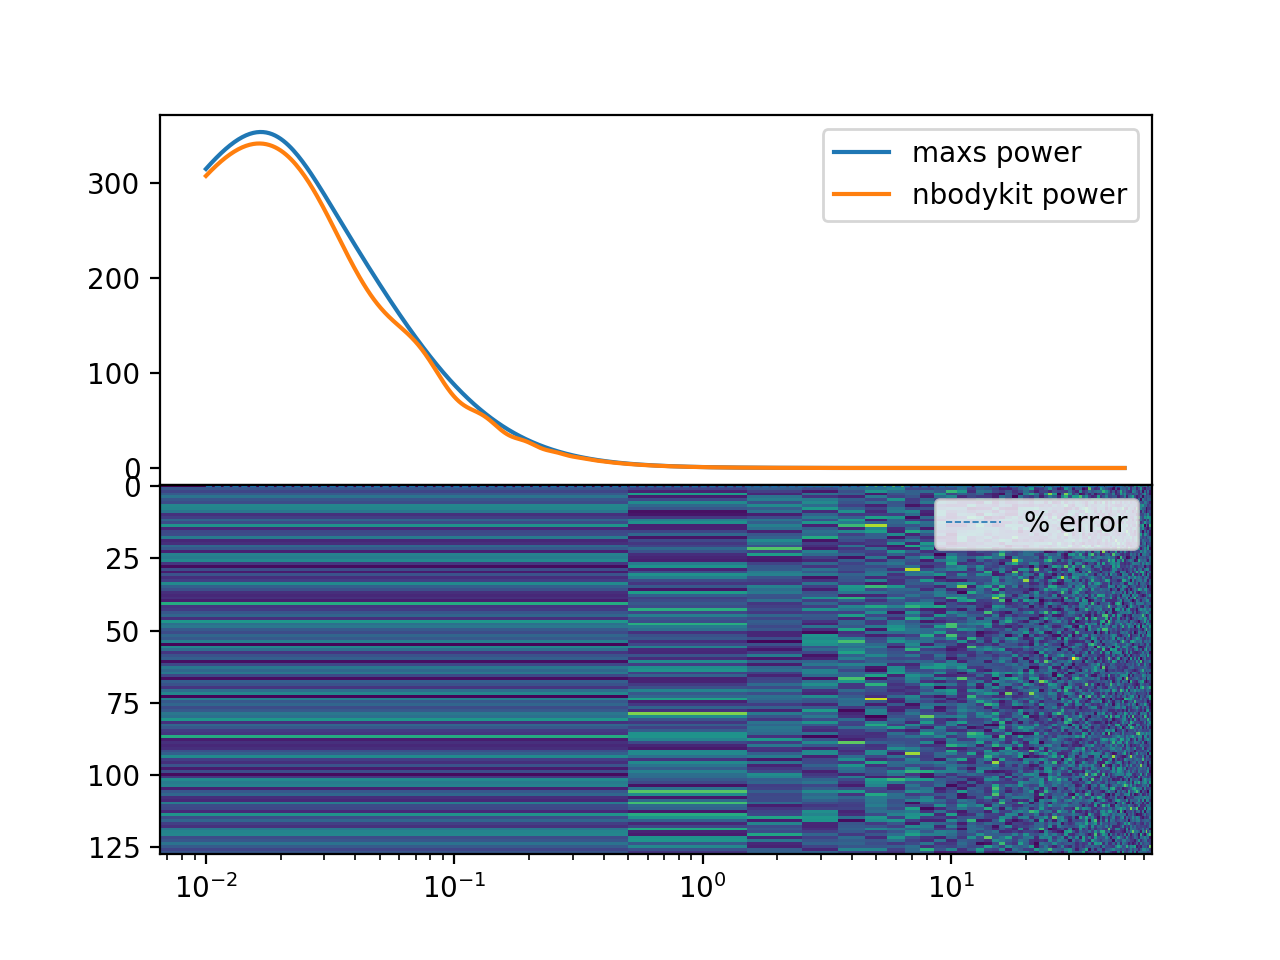

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0})
ax1.semilogx(k, p, label='maxs power')
ax1.semilogx(k, cos_pow, label='nbodykit power')

ax1.legend()
ax2.semilogx(k, error, '--', label='% error', lw=.6)
ax2.legend()

In [36]:
vjp = tape.get_vjp()
_Omega0_m = vjp.compute(init=dict(_Pk=1), vout='_Omega0_m')

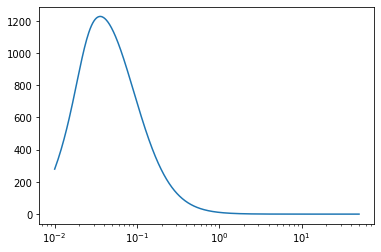

In [37]:
plt.figure()
plt.semilogx(k, _Omega0_m)

In [179]:
cosmo.Omega0_m

0.308

In [73]:
from vmad.lib import fastpm
from mpi4py import MPI

In [151]:
pm = fastpm.ParticleMesh(Nmesh=[128] * 3,
                         BoxSize=[256] * 3,
                         comm=MPI.COMM_WORLD,
                         resampler='cic')

In [152]:
rho = pm.generate_whitenoise(seed=1, unitary=False, type='complex')

In [161]:
pk = rho.apply(lambda k,v:get_pklin.build(Omega0_b = cosmo.Omega0_b, h=cosmo.h, Tcmb0=cosmo.Tcmb0, C=cosmo.C, \
                                    H0=cosmo.H0, n=cosmo.n_s, z=1, k=k).compute(init=dict(Omega0_m = cosmo.Omega0_m), vout='Pk'))
    

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

In [155]:
rho       = rho.apply(lambda k, v:)

[array([[ 0.        ,  0.0166259 ,  0.03325179,  0.04987769,  0.06650359,
         0.08312949,  0.09975538,  0.11638128,  0.13300718,  0.14963308,
         0.16625897,  0.18288487,  0.19951077,  0.21613667,  0.23276256,
         0.24938846,  0.26601436,  0.28264026,  0.29926615,  0.31589205,
         0.33251795,  0.34914384,  0.36576974,  0.38239564,  0.39902154,
         0.41564743,  0.43227333,  0.44889923,  0.46552513,  0.48215102,
         0.49877692,  0.51540282,  0.53202872,  0.54865461,  0.56528051,
         0.58190641,  0.59853231,  0.6151582 ,  0.6317841 ,  0.64841   ,
         0.66503589,  0.68166179,  0.69828769,  0.71491359,  0.73153948,
         0.74816538,  0.76479128,  0.78141718,  0.79804307,  0.81466897,
         0.83129487,  0.84792077,  0.86454666,  0.88117256,  0.89779846,
         0.91442436,  0.93105025,  0.94767615,  0.96430205,  0.98092794,
         0.99755384,  1.01417974,  1.03080564,  1.04743153, -1.06405743,
        -1.04743153, -1.03080564, -1.01417974, -0.

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in power
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

In [149]:
%debug

> <ipython-input-141-1a360920f121>(18)get_pklin()
     16     alpha_gamma = sub(1, add(mul(mul(0.328, log(431*Omh2)), f_baryon), \
     17                         mul(mul(0.38, log(22.3*Omh2)), power(f_baryon, 2))))
---> 18     k_shape = k.shape
     19     k = np.ndarray.flatten(np.asarray(k)) * h  # in 1/Mpc now
     20     ks = mul(k, div(sound_horizon, h))

ipdb> type(k)
<class 'pmesh.pm.xslab'>
ipdb> exit


In [110]:
A = np.arange(0, 100)
A = A.reshape(10, 5, 2)

In [92]:
%debug

> <ipython-input-10-884da6a75a9d>(7)apl()
      5 
      6     def apl(node, x):
----> 7         return dict(y = np.log(x))
      8     def vjp(node, _y, x):
      9         return dict(_x = 1/x*_y)

ipdb> x
array([array([[  5.43656366,   5.68298865,   5.98309409,   6.26473553,
          6.54277827,   6.82001717,   7.09700413,   7.37389254,
          7.65073613,   7.92755699,   8.20436533,   8.48116633,
          8.75796278,   9.0347563 ,   9.31154786,   9.58833807,
          9.86512733,  10.1419159 ,  10.41870395,  10.69549163,
         10.97227901,  11.24906617,  11.52585315,  11.80263999,
         12.07942672,  12.35621336,  12.63299993,  12.90978643,
         13.18657289,  13.4633593 ,  13.74014568,  14.01693203,
         14.29371835,  14.57050465,  14.84729094,  15.12407721,
         15.40086346,  15.6776497 ,  15.95443593,  16.23122216,
         16.50800837,  16.78479458,  17.06158078,  17.33836698,
         17.61515317,  17.89193936,  18.16872554,  18.44551172,
         18.72229

In [138]:
A= np.ndarray(np.arange(0,10))
A.apply(lambda A: A*3)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'